# Обучение модели.
Ноутбук выполнялся в kaggle.

In [1]:
!pip install psycopg2-binary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 43.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine

import seaborn as sns
import matplotlib.pyplot as plt

import gc
import os
from dotenv import load_dotenv

from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def get_catboost_model(params, X_train, y_train, X_test, y_test, object_cols):
    """ Создание,обучение и проверка модели CatBoostClassifier. """
    catboost = CatBoostClassifier(**params)
    catboost.fit(X_train, y_train, object_cols)
    
    print(f"ROC_AUC на трейне: {roc_auc_score(y_train, catboost.predict_proba(X_train)[:, 1])}")
    print(f"ROC_AUC на тесте: {roc_auc_score(y_test, catboost.predict_proba(X_test)[:, 1])}")

    y_pred = catboost.predict(X_test)
    y_pred_train = catboost.predict(X_train)
    print(f'Accuracy test {accuracy_score(y_test, y_pred)}, Accuracy train {accuracy_score(y_train, y_pred_train)}')
    
    return catboost

In [4]:
def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [5]:
# Загружаем доступы к базе данных соцальной сети Karpov Courses
load_dotenv(r'/kaggle/input/karpov-startml-db/env')

True

In [6]:
POSTGRESUSER = os.environ['POSTGRESUSER']
POSTGRES_PASSWORD = os.environ['POSTGRES_PASSWORD']
POSTGRES_HOST = os.environ['POSTGRES_HOST']
POSTGRES_PORT = os.environ['POSTGRES_PORT']
POSTGRES_DATABASE = os.environ['POSTGRES_DATABASE']

In [7]:
str_con_db = f'postgresql://{POSTGRESUSER}:{POSTGRES_PASSWORD}@{POSTGRES_HOST}:{POSTGRES_PORT}/{POSTGRES_DATABASE}'

In [8]:
engine = create_engine(str_con_db)

## Загрузка признаков пользователей и постов из таблиц БД.

In [9]:
# Загрузка признаков пользователей.
user_info_data = pd.read_sql("""SELECT * FROM pavel55645_users_lesson_22""", con=engine)

In [10]:
user_info_data

,index,user_id,gender,age,country,city,exp_group,business,covid,entertainment,movie,politics,sport,tech
0,0,200,1,34,Russia,Degtyarsk,3,0.071429,0.096774,0.285714,0.170455,0.068966,0.109375,0.153846
1,1,201,0,37,Russia,Abakan,0,0.103448,0.063953,0.121212,0.122677,0.013889,0.023256,0.137931
2,2,202,1,17,Russia,Smolensk,4,0.052632,0.139241,0.037037,0.126812,0.254237,0.168831,0.000000
3,3,203,0,18,Russia,Moscow,1,0.157895,0.183099,0.181818,0.182482,0.200000,0.224490,0.222222
4,4,204,0,36,Russia,Anzhero-Sudzhensk,3,0.125000,0.258065,0.200000,0.140625,0.100000,0.117647,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163200,163200,168548,0,36,Russia,Kaliningrad,4,0.083333,0.072289,0.105263,0.047945,0.025641,0.000000,0.250000
163201,163201,168549,0,18,Russia,Tula,2,0.000000,0.074627,0.000000,0.063158,0.225806,0.160000,0.000000
163202,163202,168550,1,41,Russia,Yekaterinburg,4,0.034483,0.117647,0.086957,0.135802,0.000000,0.030303,0.142857
163203,163203,168551,0,38,Russia,Moscow,3,0.047619,0.131148,0.176471,0.110000,0.026316,0.062500,0.066667


In [11]:
user_info_data = user_info_data.drop(['index'], axis=1)
user_info_data = user_info_data.set_index(['user_id'])

In [12]:
# Загрузка признаков постов.
posts_info_data  = pd.read_sql("""SELECT * FROM pavel55645_posts_info_lesson_22""", con=engine)

## Загрузка feed_data из файла csv и подготовка данных к обучению модели.

In [13]:
feed_data = pd.read_csv(r'/kaggle/input/karpov-startml-feed-data/feed_data.csv')

In [14]:
feed_data

,timestamp,user_id,post_id,target
0,2021-12-15 12:19:13,15743,3907,0
1,2021-10-27 16:36:43,11962,222,1
2,2021-10-30 14:39:36,12328,1342,0
3,2021-10-02 12:58:57,12635,4313,0
4,2021-10-02 11:26:53,17258,4880,1
...,...,...,...,...
2400485,2021-10-17 17:44:15,20978,2115,1
2400486,2021-12-24 19:29:20,13016,996,0
2400487,2021-11-16 09:33:43,20299,6092,1
2400488,2021-12-23 09:08:00,5758,6076,1


Подготовка данных для обучения модели. Соединяем все таблицы.

In [15]:
df = pd.merge(feed_data,
              posts_info_data,
              on='post_id',
              how='left')

In [16]:
df = pd.merge(df,
              user_info_data,
              on='user_id',
              how='left')

In [17]:
df.columns

Index(['timestamp', 'user_id', 'post_id', 'target', 'index', 'text', 'topic',
       'TotalTfIdf', 'MaxTfIdf', 'MeanTfIdf', 'TextCluster',
       'DistanceTo1thCluster', 'DistanceTo2thCluster', 'DistanceTo3thCluster',
       'DistanceTo4thCluster', 'DistanceTo5thCluster', 'DistanceTo6thCluster',
       'DistanceTo7thCluster', 'DistanceTo8thCluster', 'DistanceTo9thCluster',
       'DistanceTo10thCluster', 'DistanceTo11thCluster',
       'DistanceTo12thCluster', 'DistanceTo13thCluster',
       'DistanceTo14thCluster', 'DistanceTo15thCluster', 'gender', 'age',
       'country', 'city', 'exp_group', 'business', 'covid', 'entertainment',
       'movie', 'politics', 'sport', 'tech'],
      dtype='object')

Выделим признаки из timestamp. Возьмём час и месяц.

In [18]:
df['hour'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.hour)
df['month'] = pd.to_datetime(df['timestamp']).apply(lambda x: x.month)

In [19]:
df = df.drop(['index','text'], axis=1)
df = df.set_index(['user_id', 'post_id'])

In [20]:
# Определим временной диапазон постов.
max(df.timestamp), min(df.timestamp)

('2021-12-29 23:51:06', '2021-10-01 06:01:40')

Разделим данные на тренировочную и тестовую части по времени поста. За отсечку возьмем, например 2021-12-15

In [21]:
df_train = df[df.timestamp < '2021-12-15']
df_test = df[df.timestamp >= '2021-12-15']

df_train = df_train.drop('timestamp', axis=1)
df_test = df_test.drop('timestamp', axis=1)

X_train = df_train.drop('target', axis=1)
X_test = df_test.drop('target', axis=1)

y_train = df_train['target']
y_test = df_test['target']

y_train.shape, y_test.shape

((1975667,), (424823,))

Проверим баланс тренировочной и тестовой выборки.

In [22]:
y_train.value_counts()

0    1008441
1     967226
Name: target, dtype: int64

In [23]:
y_test.value_counts()

1    228617
0    196206
Name: target, dtype: int64

In [24]:
# Список колонок признаков.
X_train.columns

Index(['topic', 'TotalTfIdf', 'MaxTfIdf', 'MeanTfIdf', 'TextCluster',
       'DistanceTo1thCluster', 'DistanceTo2thCluster', 'DistanceTo3thCluster',
       'DistanceTo4thCluster', 'DistanceTo5thCluster', 'DistanceTo6thCluster',
       'DistanceTo7thCluster', 'DistanceTo8thCluster', 'DistanceTo9thCluster',
       'DistanceTo10thCluster', 'DistanceTo11thCluster',
       'DistanceTo12thCluster', 'DistanceTo13thCluster',
       'DistanceTo14thCluster', 'DistanceTo15thCluster', 'gender', 'age',
       'country', 'city', 'exp_group', 'business', 'covid', 'entertainment',
       'movie', 'politics', 'sport', 'tech', 'hour', 'month'],
      dtype='object')

## Обучение модели.

Категориальные колонки. По условиям задания exp_group - зашифрованная информация о пользователях. Про этот признак ничего не известно, возможно это просто кластеризация пользователей по группам. Будем считать её категориальным признаком.

In [25]:
object_cols = ['topic', 'gender', 'country', 'city', 'exp_group']

По условиям задания используется метрика HitRate@5:   
Она принимает значение 1, если среди предложенных 5 рекомендаций хотя бы 1 получил в итоге like от пользователя. Даже если все 5 предложенных постов в итоге будут оценены пользователем, все равно hitrate будет равен 1. Метрика бинарная. В противном случае, если ни один из предложенных постов не был оценен пользователем, hitrate  принимает значение 0.  
На мой взгляд, также важно предсказывать посты, которые пользователь не будет лайкать. В ходе обучения моделей будет использоваться метрика accuracy. Эту метрику просто интерпретировать - она показывет долю правильно предсказанных ответов. 

Посмотрим как меняется качество модели от глубины деревьев.

In [26]:
n_depth = 4
params = {'iterations':1000,
          'learning_rate':0.5,
          'loss_function':'Logloss',
          'custom_loss':'Accuracy',
          'task_type':"GPU",
          'devices':'0:1',
          'logging_level':'Silent',
          'random_seed':42,
          'depth':n_depth}

catboost_4 = get_catboost_model(params, X_train, y_train, X_test, y_test, object_cols)
catboost_4.save_model('catboost_model_4',format="cbm")

ROC_AUC на трейне: 0.7308232735252902
ROC_AUC на тесте: 0.7070405389644042
Accuracy test 0.6576644861507027, Accuracy train 0.6664478376163594


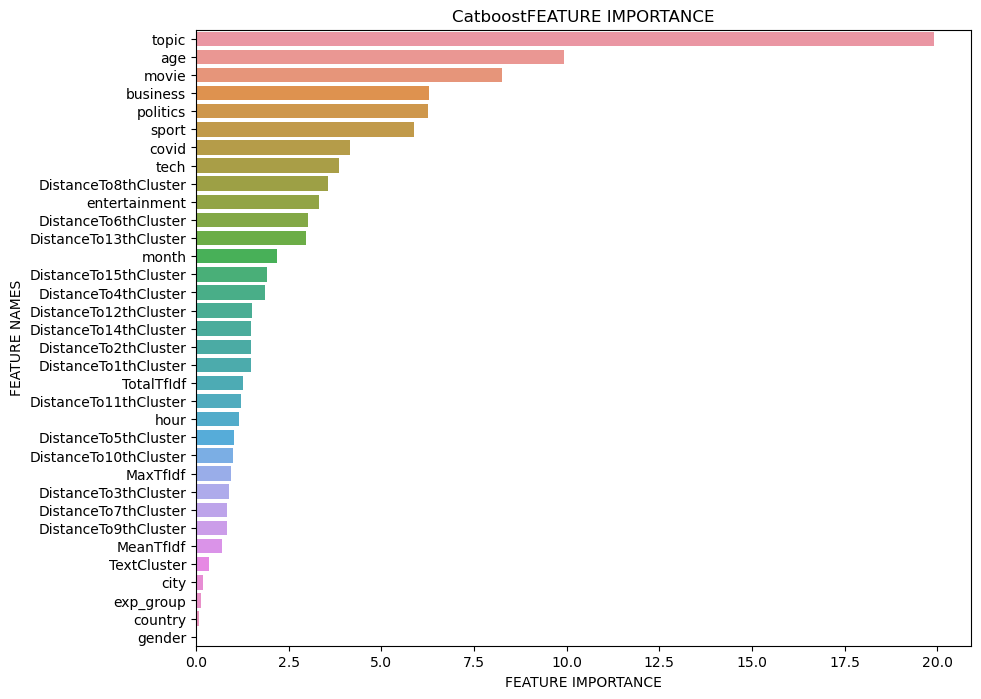

In [27]:
plot_feature_importance(catboost_4.feature_importances_,X_train.columns,'Catboost')

In [28]:
n_depth = 5
params = {'iterations':1000,
          'learning_rate':0.5,
          'loss_function':'Logloss',
          'custom_loss':'Accuracy',
          'task_type':"GPU",
          'devices':'0:1',
          'logging_level':'Silent',
          'random_seed':42,
          'depth':n_depth}

catboost_5 = get_catboost_model(params, X_train, y_train, X_test, y_test, object_cols)
catboost_5.save_model('catboost_model_5',format="cbm")

ROC_AUC на трейне: 0.7390162565123287
ROC_AUC на тесте: 0.7111525797405649
Accuracy test 0.6608728811763959, Accuracy train 0.6728132828052501


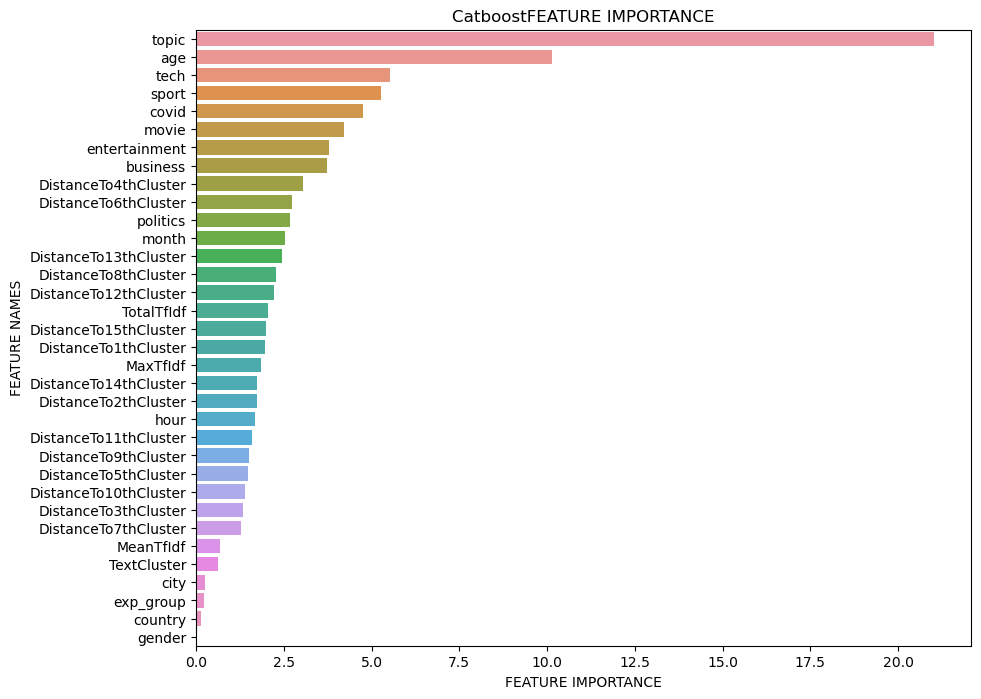

In [29]:
plot_feature_importance(catboost_5.feature_importances_,X_train.columns,'Catboost')

In [30]:
n_depth = 6
params = {'iterations':1000,
          'learning_rate':0.5,
          'loss_function':'Logloss',
          'custom_loss':'Accuracy',
          'task_type':"GPU",
          'devices':'0:1',
          'logging_level':'Silent',
          'random_seed':42,
          'depth':n_depth}

catboost_6 = get_catboost_model(params, X_train, y_train, X_test, y_test, object_cols)
catboost_6.save_model('catboost_model_6',format="cbm")

ROC_AUC на трейне: 0.7465344683768607
ROC_AUC на тесте: 0.7123569670991947
Accuracy test 0.6629302085809855, Accuracy train 0.6785197100523519


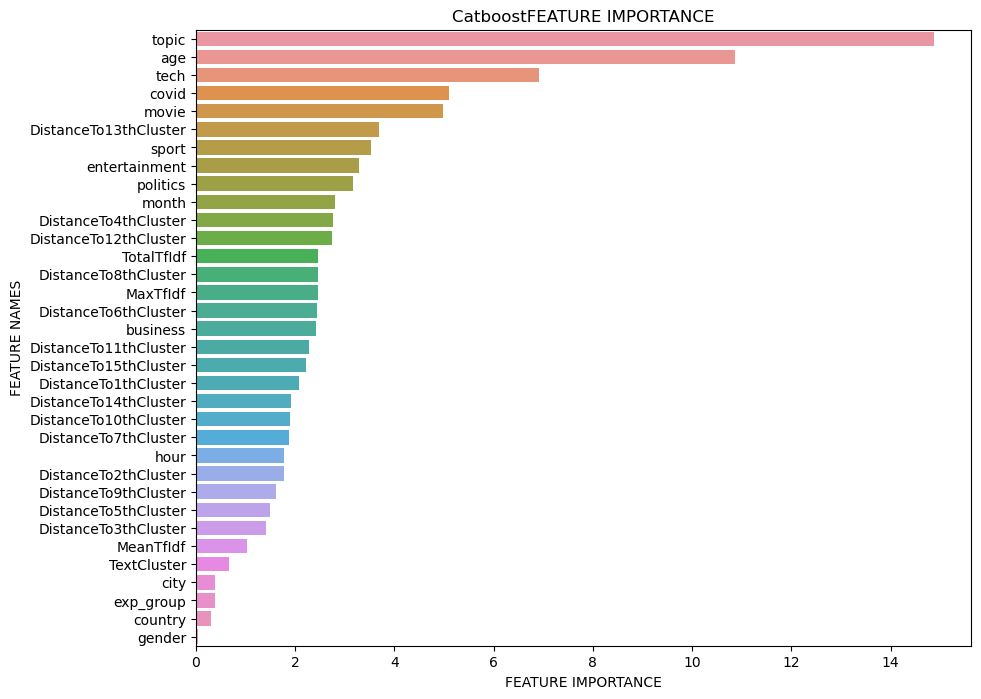

In [31]:
plot_feature_importance(catboost_6.feature_importances_,X_train.columns,'Catboost')

In [32]:
n_depth = 7
params = {'iterations':1000,
          'learning_rate':0.5,
          'loss_function':'Logloss',
          'custom_loss':'Accuracy',
          'task_type':"GPU",
          'devices':'0:1',
          'logging_level':'Silent',
          'random_seed':42,
          'depth':n_depth}

catboost_7 = get_catboost_model(params, X_train, y_train, X_test, y_test, object_cols)
catboost_7.save_model('catboost_model_7',format="cbm")

ROC_AUC на трейне: 0.7577883424181504
ROC_AUC на тесте: 0.7109058925345217
Accuracy test 0.6621228135011522, Accuracy train 0.686337829198949


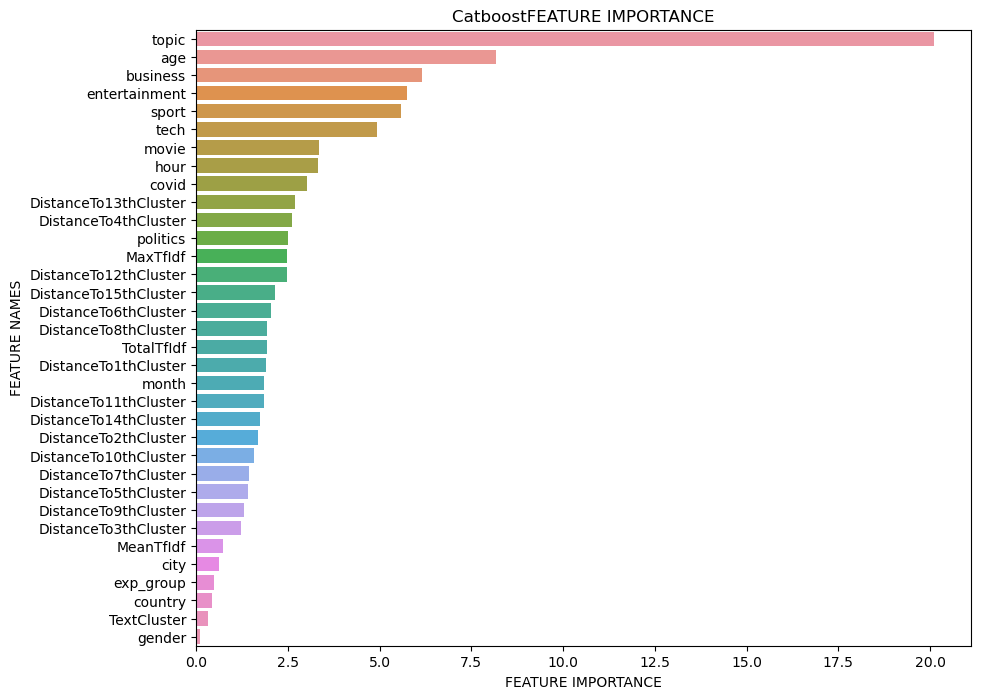

In [33]:
plot_feature_importance(catboost_7.feature_importances_,X_train.columns,'Catboost')

In [34]:
n_depth = 8
params = {'iterations':1000,
          'learning_rate':0.5,
          'loss_function':'Logloss',
          'custom_loss':'Accuracy',
          'task_type':"GPU",
          'devices':'0:1',
          'logging_level':'Silent',
          'random_seed':42,
          'depth':n_depth}

catboost_8 = get_catboost_model(params, X_train, y_train, X_test, y_test, object_cols)
catboost_8.save_model('catboost_model_8',format="cbm")

ROC_AUC на трейне: 0.7759333076521571
ROC_AUC на тесте: 0.7061777721078567
Accuracy test 0.6597947851222744, Accuracy train 0.6997940442392366


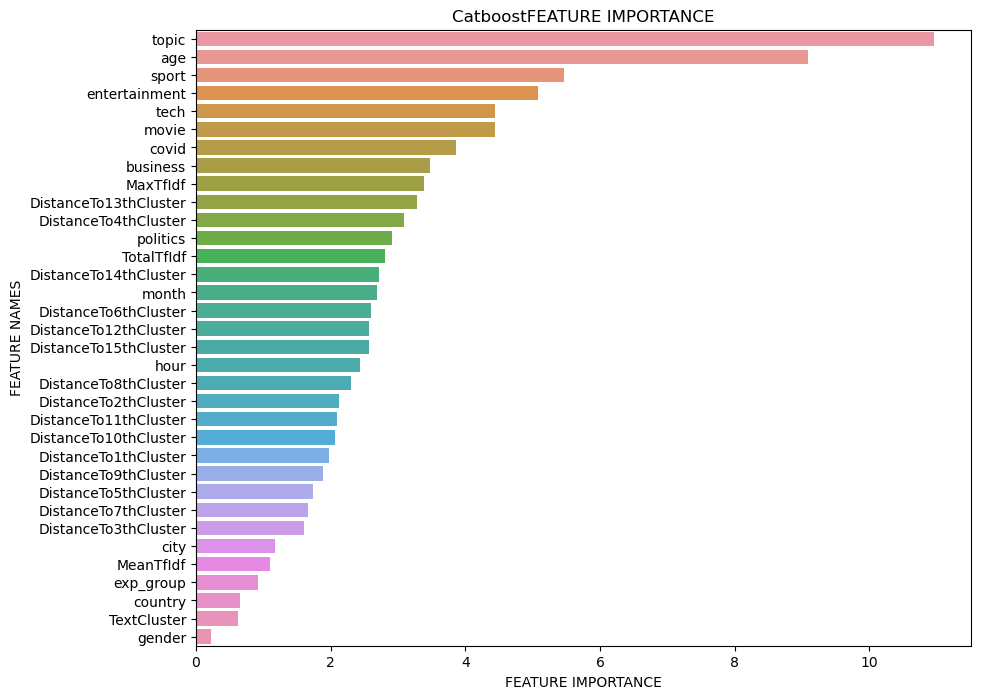

In [35]:
plot_feature_importance(catboost_8.feature_importances_,X_train.columns,'Catboost')

Самая оптимальная модель с глубиной деревьев 6. В дальнейшем происходит переобучение модели, качество на тренировочных данных растёт, на тестовых - падает. Попробуем в этой модели увеличить learning_rate.

In [36]:
n_depth = 6
params = {'iterations':1000,
          'learning_rate':1,
          'loss_function':'Logloss',
          'custom_loss':'Accuracy',
          'task_type':"GPU",
          'devices':'0:1',
          'logging_level':'Silent',
          'random_seed':42,
          'depth':n_depth}

catboost_6_1 = get_catboost_model(params, X_train, y_train, X_test, y_test, object_cols)
catboost_6_1.save_model('catboost_model_6_1',format="cbm")

ROC_AUC на трейне: 0.749038306787623
ROC_AUC на тесте: 0.7029629299714347
Accuracy test 0.6564710479423195, Accuracy train 0.6800498262105912


Самая оптимальная модель по Accuracy test = 0.663 и ROC_AUC = 0.712, имеет параметры n_depth = 6 и learning_rate = 0.5. Эту обученную модель будем внедрять в работающий сервис.  
После выделения новых признаков пользователей, доли лайкнутых постов по топикам, на первое место по важности вышел признак topic. Второй по важности признак - возраст пользователя, age. Т.е. лайк поста в основном зависит от возраста пользователя и топика поста.